In [ ]:
#Upload the kaggle airbus challenge dataset json source file to gain acces to the dataset
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c airbus-ship-detection

100% 28.6G/28.6G [04:01<00:00, 178MB/s]
100% 28.6G/28.6G [04:01<00:00, 127MB/s]


In [ ]:
!unzip airbus-ship-detection.zip

In [ ]:
# !wget 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth'
# !wget 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth'
!wget 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth'

--2025-08-24 14:15:24--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.65.3.36, 18.65.3.5, 18.65.3.98, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.65.3.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b_01ec64.pth’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M   315MB/s    in 1.1s    

2025-08-24 14:15:25 (315 MB/s) - ‘sam_vit_b_01ec64.pth’ saved [375042383/375042383]



In [ ]:
import torch
import cv2
import supervision as sv
from segment_anything import SamPredictor
import numpy as np
import os
import pandas as pd
from PIL import Image
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from torchvision import transforms
from peft import LoraConfig, get_peft_model
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from statistics import mean
from torchvision import datasets, transforms
from torch.optim import Adam
from torch.nn.functional import threshold, normalize
import yaml
import random

In [ ]:
train_dataset_path = ''
test_dataset_path = ''
weight_path = ''
csv_path = ''

In [ ]:
df = pd.read_csv(csv_path)
print(df.columns)

Index(['ImageId', 'EncodedPixels'], dtype='object')


In [ ]:
def decode_encoded_pixels(encoded_pixels, shape):
    mask_flat = np.zeros(shape[0] * shape[1], dtype=np.uint8)  # Create a flat mask
    if isinstance(encoded_pixels, str) and encoded_pixels.strip():
        pixels = list(map(int, encoded_pixels.split()))
        for i in range(0, len(pixels), 2):
            start = pixels[i] - 1  # starting index (adjusted for 0-based indexing)
            length = pixels[i + 1]  # length of the mask
            mask_flat[start:start + length] = 1
    return mask_flat.reshape(shape)

In [ ]:
masks_dict = {}

for idx in range(len(df)):
    img_id = df.iloc[idx]["ImageId"]  # Get the ImageId at the current row
    encoded_pixels = df.iloc[idx]["EncodedPixels"]  # Get encoded pixel data for the current ImageId

    # Generate mask based on encoded pixels
    if pd.isna(encoded_pixels):
        mask = np.zeros((768, 768), dtype=np.uint8)  # Create a blank mask if there are no encoded pixels
    else:
        mask = decode_encoded_pixels(encoded_pixels, (768, 768))  # Decode the mask based on the encoded pixels

    # If the image ID already exists, add the new mask to the existing one
    if img_id in masks_dict:
        masks_dict[img_id] += mask  # Add the new mask to the existing mask for this ImageId
    else:
        masks_dict[img_id] = mask  # If this is the first mask for this ImageId, create a new entry in masks_dict

print(f"Number of valid masks found: {len(masks_dict)}")

# Example of accessing a mask tensor by ImageId
if masks_dict:
    example_img_id = list(masks_dict.keys())[0]
    example_mask = masks_dict[example_img_id]
    print(f"Mask for {example_img_id} found and ready for use.")
else:
    print("No valid masks were found.")


Number of valid masks found: 192556
Mask for 00003e153.jpg found and ready for use.


In [ ]:
# List all files in the images folder
image_files = os.listdir(train_dataset_path)

# # Step 2: Extract ImageIds from filenames (remove the ".jpg" extension)
# image_ids_from_files = [img_file.split('.')[0] for img_file in image_files]

# having the .jpg extension
image_ids_from_files = set(image_files)

# Check which ImageIds are present in masks_dict
valid_mask_ids = set(masks_dict.keys())

# Find matching and missing ImageIds
matching_ids2 = valid_mask_ids.intersection(image_ids_from_files)
missing_from_files2 = valid_mask_ids - set(image_ids_from_files)  # Convert list to set
missing_from_masks2 = set(image_ids_from_files) - valid_mask_ids  # Convert list to set

# Print results
print(f"Matching ImageIds: {len(matching_ids2)}")
print(f"Missing from image folder: {len(missing_from_files2)}")
print(f"Missing from masks dictionary: {len(missing_from_masks2)}")

Matching ImageIds: 192556
Missing from image folder: 0
Missing from masks dictionary: 0


In [ ]:
imageids_from_csv = df["ImageId"].unique().tolist()
print(len(imageids_from_csv))

192556


In [ ]:
# Transform function
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize masks if necessary
    transforms.ToTensor(),
])

# Create the "masks" directory if it doesn't exist
masks_dir = ''  # Adjust this path & set it as a folder
os.makedirs(masks_dir, exist_ok=True)
count = 0

# Iterate over a copy of the dictionary's keys to avoid modifying the dictionary during iteration
for img_id in list(masks_dict.keys()):
    # Check if the file exists
    if os.path.exists(f'{masks_dir}/{img_id}_mask.pt'):
        print("File exists.")
        del masks_dict[img_id]
        count += 1
        print(f"Masks processed: {count}")
    else:
        print("File does not exist.")
        mask = masks_dict[img_id]

        # rgba_mask = binary_to_rgba(mask)
        # transformed_mask = sam.set_image(rgba_mask)

        # Convert mask to a PIL image and apply transformations
        mask_image = Image.fromarray(np.clip(mask, 0, 1) * 255)
        transformed_mask = transform(mask_image)

        # Save as a tensor file in the "masks" directory
        mask_file_path = os.path.join(masks_dir, f"{img_id}_mask.pt")
        torch.save(transformed_mask, mask_file_path)  # Save as a tensor file

        # Optional: Remove from masks_dict if memory usage is a concern
        del masks_dict[img_id]

        count += 1
        print(f"Masks processed: {count}")



In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize masks if necessary
    transforms.ToTensor(),
])

# Define the path to the temporary disk directory for saving images
images_dir = ''  # Adjust the path as needed & set it as a folder
os.makedirs(images_dir, exist_ok=True)  # Create the directory if it doesn't exist

count1 = 0
error = 0

for image_id in imageids_from_csv:
    img_path = os.path.join(train_dataset_path, f"{image_id}")

    if os.path.exists(f'{images_dir}{image_id}_image.pt'):
      print("File exists.")
      count1 += 1
      print(f"Images processed: {count1}")
    else:
      print("File does not exist in folder.")
      try:
          image = Image.open(img_path).convert("RGB")
      except OSError as e:
          print(f"Error loading image {img_path}: {e}, skipping...: errors: {error}")
          error += 1
          continue

      # Apply transformations to the image
      transformed_image = transform(image)

      # Save the transformed image tensor to a file
      image_file_path = os.path.join(images_dir, f"{image_id}_image.pt")
      torch.save(transformed_image, image_file_path)  # Save as a tensor file

      count1 += 1
      print(f"Images processed: {count1}")


In [ ]:
# List all files in the images folder
image_files = os.listdir('/content/images')

# # Step 2: Extract ImageIds from filenames (remove the ".jpg" extension)
image_ids_from_files = {img_file.split('_')[0] for img_file in image_files if img_file.endswith('_image.pt')}

csv_imageids = set(df['ImageId'].unique())

# Find matching and missing ImageIds
matching_ids3 = csv_imageids.intersection(image_ids_from_files)
missing_from_files3 = csv_imageids - set(image_ids_from_files)  # Convert list to set
missing_from_masks3 = set(image_ids_from_files) - csv_imageids  # Convert list to set

# Print results
print(f"Matching ImageIds: {len(matching_ids3)}")
print(f"Missing from image folder: {len(missing_from_files3)}")
print(f"Missing from csv file: {len(missing_from_masks3)}")

Matching ImageIds: 192555
Missing from image folder: 1
Missing from csv file: 0


In [ ]:
print("Missing ImageIds from files:")
for image_id in missing_from_files3:
    print(image_id)

Missing ImageIds from files:
6384c3e78.jpg


6384c3e78.jpg has a problem opening as rgb. Error message: "Error loading specific image /content/train_v2/6384c3e78.jpg: image file is truncated (51 bytes not processed)". meaning its incomplete or corrupted

In [ ]:
# Specify the ImageId of the image that failed to load
specific_image_id = '6384c3e78.jpg'  # Replace with the actual ImageId

# Retry loading and processing the specific image
try:
    specific_img_path = os.path.join(train_dataset_path, f"{specific_image_id}")
    image = Image.open(specific_img_path).convert("RGB")

    # Apply transformations to the image
    transformed_image = transform(image)

    # Save the transformed image tensor to a file
    specific_image_file_path = os.path.join(images_dir, f"{specific_image_id}_image.pt")
    torch.save(transformed_image, specific_image_file_path)  # Save as a tensor file

    print(f"Processed specific image: {specific_image_id}")
except OSError as e:
    print(f"Error loading specific image {specific_img_path}: {e}")

Error loading specific image /content/train_v2/6384c3e78.jpg: image file is truncated (51 bytes not processed)


so you can try to delete the groundtruth mask related to "6384c3e78.jpg"

In [ ]:
import sys
sys.path.append("/PATH/TO/THE/SAM/FOLDER/configuration/")

In [ ]:
from src.segment_anything import build_sam_vit_b, SamPredictor
from src.segment_anything.utils.transforms import ResizeLongestSide
import src.utils as utils
images_dir = '/content/images/'
masks_dir = '/content/masks_reformed/'

In [ ]:
class LazyTensorDataset(Dataset):
    def __init__(self, images_dir, masks_dir, processor):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.processor = processor

        self.image_files = [f for f in os.listdir(images_dir) if f.endswith("_image.pt")]
        self.dummy_indices = []
        self.non_dummy_indices = []

        for idx, img_file in enumerate(self.image_files):
            image_id = img_file.split('_')[0]
            mask_file = f"{image_id}_mask.pt"
            mask_path = os.path.join(masks_dir, mask_file)

            if not os.path.exists(mask_path) or torch.load(mask_path, map_location="cpu").sum() == 0:
                self.dummy_indices.append(idx)
            else:
                self.non_dummy_indices.append(idx)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_file = self.image_files[idx]
        image_id = img_file.split('_')[0]
        mask_file = f"{image_id}_mask.pt"

        image_tensor = torch.load(os.path.join(self.images_dir, img_file), map_location="cpu")
        mask_path = os.path.join(self.masks_dir, mask_file)

        if os.path.exists(mask_path):
            mask_tensor = torch.load(mask_path, map_location="cpu")
        else:
            mask_tensor = torch.zeros((image_tensor.shape[1], image_tensor.shape[2]), dtype=torch.uint8)

        image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
        mask_np = mask_tensor.cpu().numpy()

        original_size = mask_np.shape[-2:]
        bbox = self.get_bounding_box(mask_np)

        inputs = self.processor(image_np, original_size, bbox)
        inputs["image"] = inputs["image"].squeeze(0)  # ✅ FIX HERE
        inputs["ground_truth_mask"] = torch.from_numpy(mask_np).long()
        inputs["image_id"] = image_id
        return inputs

    def get_bounding_box(self, ground_truth_map: np.array) -> list:
        idx = np.where(ground_truth_map > 0)
        if len(idx[0]) == 0:
            return [0, 0, 0, 0]

        x_indices = idx[1]
        y_indices = idx[0]
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)

        H, W = ground_truth_map.shape[-2:]
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))

        return [x_min, y_min, x_max, y_max]

In [ ]:
class Samprocessor:
    def __init__(self, sam_model):
        super().__init__()
        self.model = sam_model
        self.transform = ResizeLongestSide(sam_model.image_encoder.img_size)
        self.reset_image()

    def __call__(self, image, original_size, prompt):
        image_torch = self.process_image(image, original_size)
        box_torch = self.process_prompt(prompt, original_size)

        inputs = {
            "image": image_torch,              # Still on CPU
            "original_size": original_size,
            "boxes": box_torch,                # Still on CPU
            "prompt": prompt,
        }
        return inputs

    def process_image(self, image, original_size):
        nd_image = np.array(image)
        input_image = self.transform.apply_image(nd_image)
        input_image_torch = torch.as_tensor(input_image)  # Removed device
        input_image_torch = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]
        return input_image_torch

    def process_prompt(self, box, original_size):
        nd_box = np.array(box).reshape((1, 4))
        box = self.transform.apply_boxes(nd_box, original_size)
        box_torch = torch.as_tensor(box, dtype=torch.float)  # Removed device
        box_torch = box_torch[None, :]
        return box_torch

    @property
    def device(self):
        return self.model.device

    def reset_image(self):
        self.is_image_set = False
        self.features = None
        self.orig_h = None
        self.orig_w = None
        self.input_h = None
        self.input_w = None

In [ ]:
def collate_fn(batch):
    return list(batch)

In [ ]:
def split_dataset(images_dir, masks_dir, processor, total_images=None, train_pct=0.6, val_pct=0.2, test_pct=0.2, batch_size=6):
    dataset = LazyTensorDataset(images_dir, masks_dir, processor)

    np.random.shuffle(dataset.dummy_indices)
    np.random.shuffle(dataset.non_dummy_indices)

    total_available = len(dataset.dummy_indices) + len(dataset.non_dummy_indices)
    total_images = min(total_images, total_available) if total_images else total_available

    dummy_ratio = len(dataset.dummy_indices) / total_available
    num_dummy = int(total_images * dummy_ratio)
    num_non_dummy = total_images - num_dummy

    selected_indices = dataset.dummy_indices[:num_dummy] + dataset.non_dummy_indices[:num_non_dummy]
    np.random.shuffle(selected_indices)

    train_size = int(train_pct * len(selected_indices))
    val_size = int(val_pct * len(selected_indices))
    test_size = len(selected_indices) - train_size - val_size

    selected_dataset = Subset(dataset, selected_indices)
    train_dataset, val_dataset, test_dataset = random_split(selected_dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=0, pin_memory=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=0, pin_memory=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=0, pin_memory=False)

    print(f"Total Images: {total_images}")
    print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

    return train_loader, val_loader, test_loader

In [ ]:
# Load the config file
with open("/content/Sam_LoRA-main/config.yaml", "r") as ymlfile:
   config_file = yaml.load(ymlfile, Loader=yaml.Loader)

In [ ]:
model_type = "vit_b"  # Specify the model type you want to use
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
sam_model = build_sam_vit_b(checkpoint=config_file["SAM"]["CHECKPOINT"]) # Load and move model to device
print("SAM Model loaded successfully!")

SAM Model loaded successfully!


In [ ]:
from peft import LoraConfig, get_peft_model
# LoRA configuration
lora_config = LoraConfig(
    r=256,  # LoRA rank
    lora_alpha=256,  # Scaling factor
    target_modules=["q_proj", "k_proj", "v_proj", "out_proj"],  # Target modules in the SAM model
    lora_dropout=0.1,  # Dropout for LoRA
    bias="none",  # Bias handling
)

# Apply LoRA to the SAM model
sam_lora_model = get_peft_model(sam_model, lora_config)

# Pass the *model* (not wrapper) to processor
processor = Samprocessor(sam_lora_model)
sam_lora_model.to(DEVICE)

In [ ]:
# Get dataloaders (split dataset smartly)
train_loader, val_loader, test_loader = split_dataset(
    images_dir,
    masks_dir,
    processor,
    total_images=192555,  # or whatever sample you want
    batch_size=6
)

Total Images: 192555
Train: 115533, Val: 38511, Test: 38511


In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, sam_lora_model.parameters()), lr=1e-4, weight_decay=0)

In [ ]:
import torch.nn.functional as F

# Dice Loss implementation
def dice_loss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = pred.view(pred.size(0), -1)
    target = target.view(pred.size(0), -1)
    intersection = (pred * target).sum(dim=1)
    union = pred.sum(dim=1) + target.sum(dim=1)
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

In [ ]:
def stacking_batch(batch, outputs):
    """
    Given the batch and outputs of SAM, stacks the tensors to compute the loss. We stack by adding another dimension.

    Arguments:
        batch(list(dict)): List of dict with the keys given in the dataset file
        outputs: list(dict): List of dict that are the outputs of SAM

    Return:
        stk_gt: Stacked tensor of the ground truth masks in the batch. Shape: [batch_size, H, W] -> We will need to add the channels dimension (dim=1)
        stk_out: Stacked tensor of logits mask outputed by SAM. Shape: [batch_size, 1, 1, H, W] -> We will need to remove the extra dimension (dim=1) needed by SAM
    """
    stk_gt = torch.stack([b["ground_truth_mask"] for b in batch], dim=0)
    stk_out = torch.stack([out["low_res_logits"] for out in outputs], dim=0)

    return stk_gt, stk_out

In [ ]:
def jaccard_index(pred, target, eps=1e-7):
    """Computes IoU (Jaccard Index) between predicted and target masks"""
    pred = pred.bool()
    target = target.bool()

    intersection = (pred & target).float().sum((1, 2))
    union = (pred | target).float().sum((1, 2))
    iou = (intersection + eps) / (union + eps)
    return iou.mean().item()  # Average IoU over batch


In [ ]:
#USING IOU as perfomance metric
num_epochs = 10  # Or any number you want

for epoch in range(num_epochs):
    sam_lora_model.train()
    epoch_loss = 0.0
    epoch_iou_total = 0.0
    num_batches = 0

    with tqdm(total=len(train_loader), desc=f"[Train] Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
        for batch in train_loader:
            # Move all tensors in the batch to DEVICE

            batch = [{k: v.to(DEVICE) if isinstance(v, torch.Tensor) else v for k, v in b.items()} for b in batch]

            outputs = sam_lora_model(batched_input= batch, multimask_output=False)

            # # Loss calculation (BCE + Dice)
            stk_gt, stk_out = stacking_batch(batch, outputs)
            stk_out = stk_out.squeeze(1).to(DEVICE)        # [B, 1, H, W]
            stk_gt = stk_gt.float().to(DEVICE)             # [B, 1, H, W] as-is
            # loss = seg_loss(stk_out, stk_gt)

            stk_gt_upsampled = F.interpolate(stk_gt, size=stk_out.shape[-2:], mode="nearest")
            loss_bce = criterion(stk_out, stk_gt_upsampled)
            loss_dice = dice_loss(stk_out, stk_gt_upsampled)
            loss = 0.2 * loss_bce + 0.8 * loss_dice

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            torch.cuda.empty_cache()

            # Compute IoU
            pred_bin = (torch.sigmoid(stk_out) > 0.5).float()
            gt_bin = (stk_gt_upsampled > 0).float()
            batch_iou = jaccard_index(pred_bin.squeeze(1), gt_bin.squeeze(1))

            # Update accumulators
            epoch_loss += loss.item()
            epoch_iou_total += batch_iou
            num_batches += 1

            pbar.set_postfix({"Loss": loss.item(), "Mean IoU": f"{batch_iou:.4f}"})
            pbar.update(1)

    avg_loss = epoch_loss / num_batches
    avg_iou = epoch_iou_total / num_batches
    print(f"\n Epoch {epoch+1} Train | Loss: {avg_loss:.4f} | IoU: {avg_iou:.4f}")

    # -------------------------
    #         VALIDATION
    # -------------------------
    sam_lora_model.eval()
    val_loss = 0.0
    val_iou_total = 0.0
    val_batches = 0

    with torch.no_grad(), tqdm(total=len(val_loader), desc=f"[Val]   Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar_val:
        for batch in val_loader:
            batch = [{k: v.to(DEVICE) if isinstance(v, torch.Tensor) else v for k, v in b.items()} for b in batch]

            outputs = sam_lora_model(batched_input=batch, multimask_output=False)

            stk_gt, stk_out = stacking_batch(batch, outputs)
            stk_out = stk_out.squeeze(1).to(DEVICE)        # [B, 1, H, W]
            stk_gt = stk_gt.float().to(DEVICE)             # [B, 1, H, W] as-is
             # loss = seg_loss(stk_out, stk_gt)

            stk_gt_upsampled = F.interpolate(stk_gt, size=stk_out.shape[-2:], mode="nearest")
            loss_bce = criterion(stk_out, stk_gt_upsampled)
            loss_dice = dice_loss(stk_out, stk_gt_upsampled)
            loss = 0.2 * loss_bce + 0.8 * loss_dice

            pred_bin = (torch.sigmoid(stk_out) > 0.5).float()
            gt_bin = (stk_gt_upsampled > 0).float()
            batch_iou = jaccard_index(pred_bin.squeeze(1), gt_bin.squeeze(1))

            val_loss += loss.item()
            val_iou_total += batch_iou
            val_batches += 1

            pbar_val.set_postfix({"Loss": loss.item(), "Mean IoU": f"{batch_iou:.4f}"})
            pbar_val.update(1)

    avg_val_loss = val_loss / val_batches
    avg_val_iou = val_iou_total / val_batches
    print(f"\n Epoch {epoch+1} Val   | Loss: {avg_val_loss:.4f} | IoU: {avg_val_iou:.4f}\n")

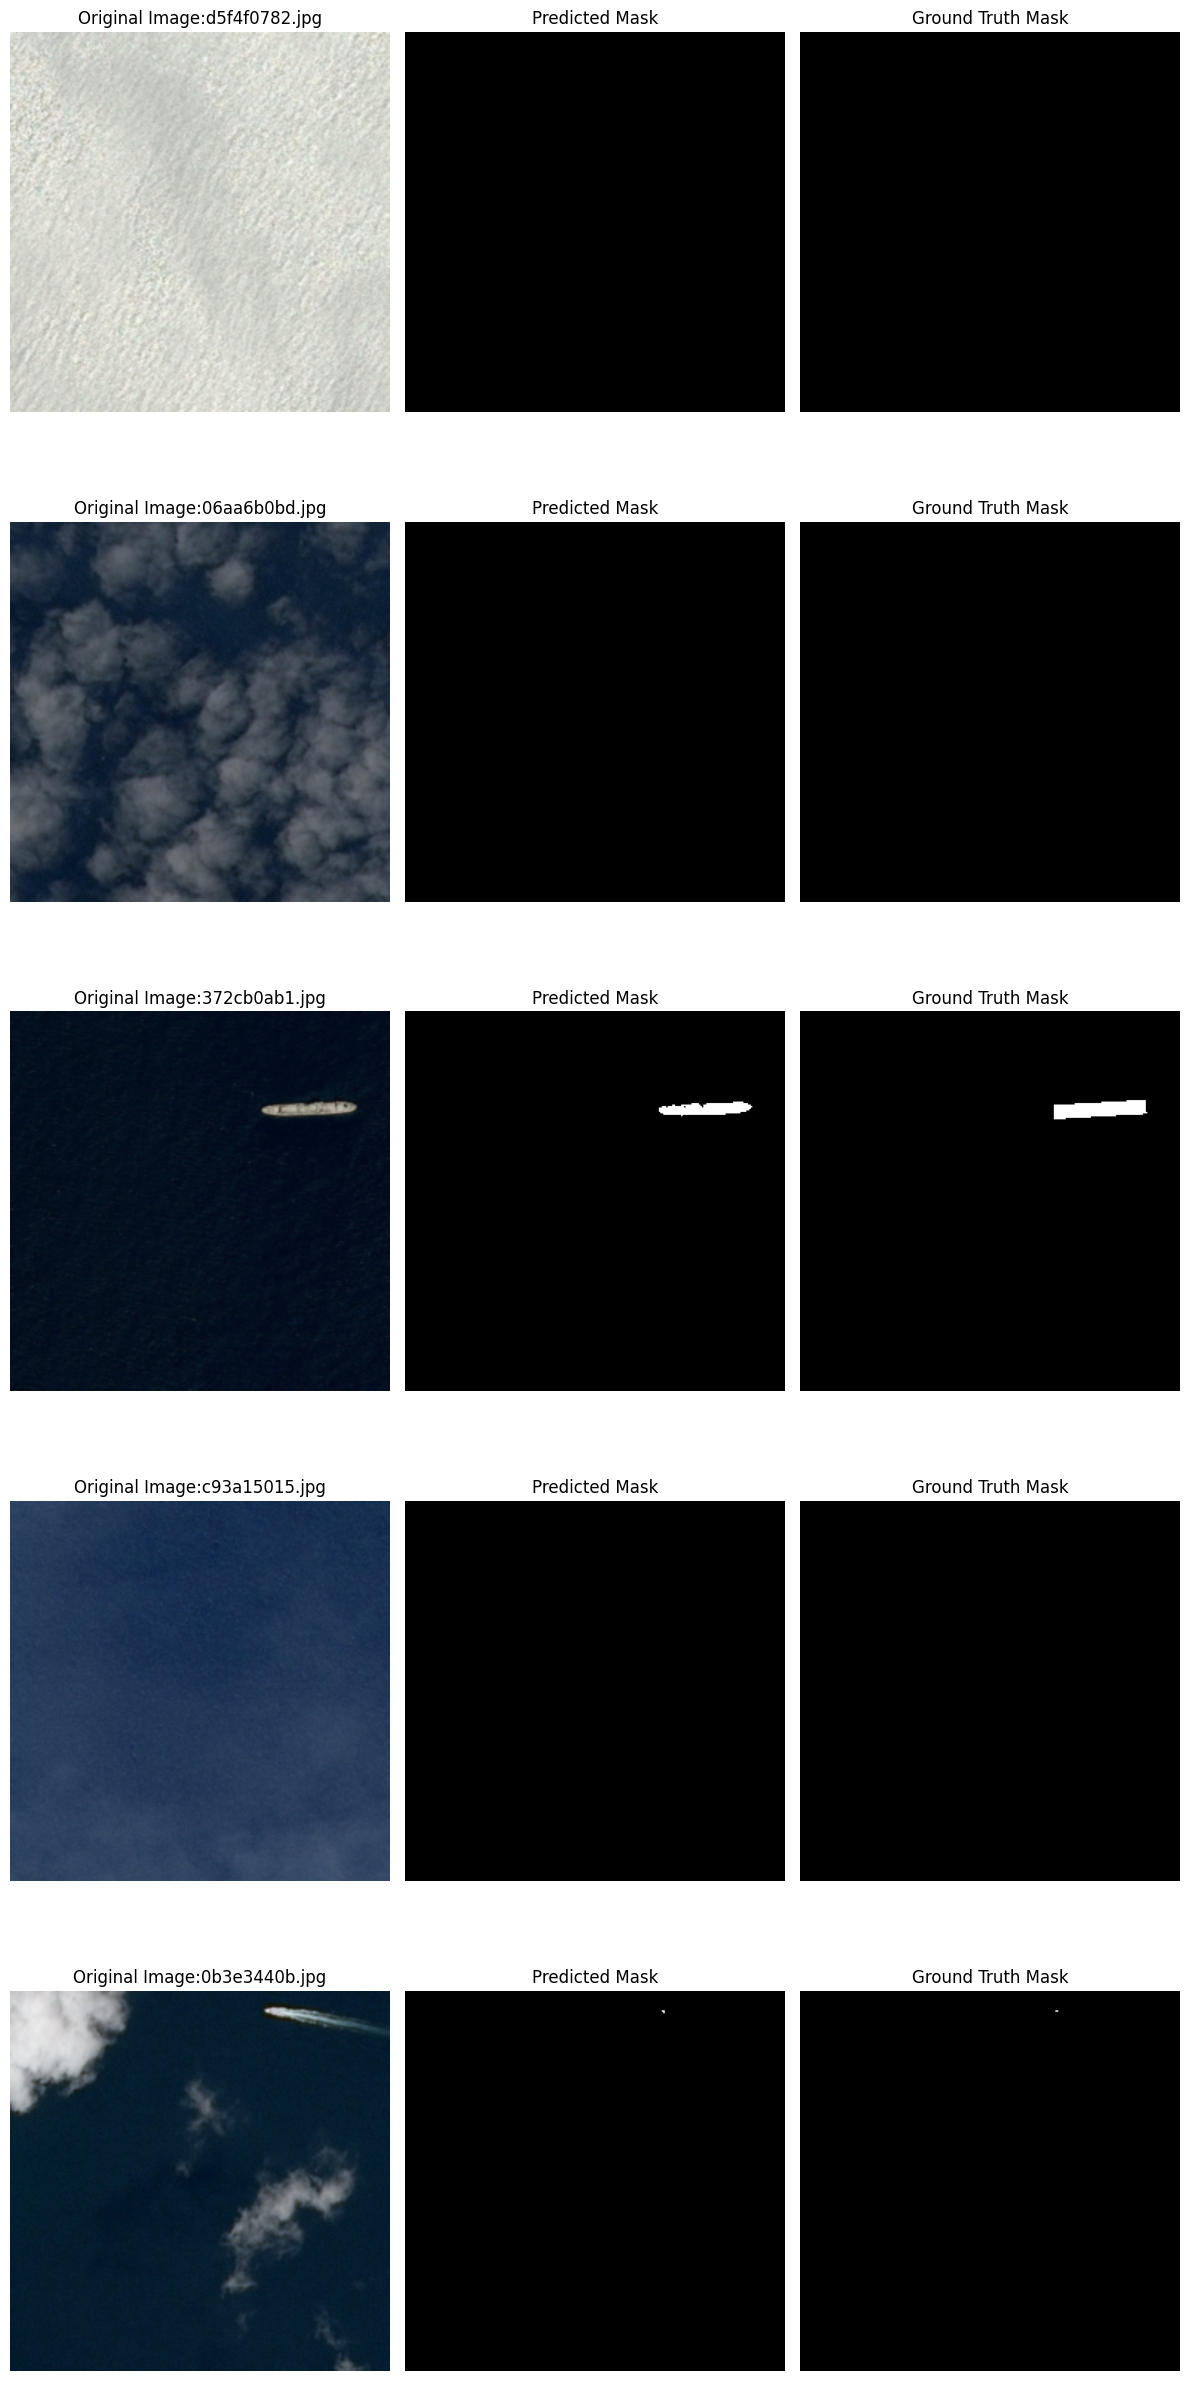

In [ ]:
n_batches = 3

# Convert DataLoader to a list of batches for random access
all_batches = list(test_loader)

for batch_num in range(n_batches):
    # Randomly sample a batch
    batch = random.choice(all_batches)

    # Move batch to device
    for sample in batch:
        for key in ["image", "boxes", "ground_truth_mask"]:
            if key in sample and isinstance(sample[key], torch.Tensor):
                sample[key] = sample[key].to(DEVICE)

    # Run inference for this batch only
    outputs = sam_lora_model(batched_input=batch, multimask_output=False)

    # Stack predicted masks [B, 1, 1, H, W] → [B, H, W]
    pred_masks = torch.stack([o["masks"] for o in outputs]).squeeze(1).cpu()

    # Stack ground truth masks [B, H, W]
    gt_masks = torch.stack([s["ground_truth_mask"] for s in batch]).cpu()

    # Stack RGB images [B, 3, H, W] → [B, H, W, 3]
    images = torch.stack([s["image"] for s in batch]).cpu()
    if images.dim() == 4:
        images = images.permute(0, 2, 3, 1)

    # Threshold predicted masks to binary
    bin_masks = (pred_masks > 0.5).float()

    # Visualize current batch
    num_samples = min(5, len(images))
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 5 * num_samples))

    for i in range(num_samples):
        axes[i, 0].imshow(images[i].numpy().astype("uint8"))
        axes[i, 0].set_title(f"Original Image:" + batch[i].get("image_id"))

        axes[i, 1].imshow(bin_masks[i].squeeze(), cmap="gray")
        axes[i, 1].set_title("Predicted Mask")

        axes[i, 2].imshow(gt_masks[i].squeeze(), cmap="gray")
        axes[i, 2].set_title("Ground Truth Mask")

        for ax in axes[i]:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

    # Clear GPU memory before moving to the next batch
    del outputs, pred_masks, gt_masks, images, bin_masks
    torch.cuda.empty_cache()

In [ ]:
# -------------------------
#         TESTING
# -------------------------
sam_lora_model.eval()
test_loss = 0.0
test_iou_total = 0.0
test_batches = 0

with torch.no_grad(), tqdm(total=len(test_loader), desc=f"[Test]  Final Evaluation", unit="batch") as pbar_test:
    for batch in test_loader:
        # Move batch to DEVICE
        batch = [{k: v.to(DEVICE) if isinstance(v, torch.Tensor) else v for k, v in b.items()} for b in batch]

        # Run inference
        outputs = sam_lora_model(batched_input=batch, multimask_output=False)

        # Stack outputs and ground truths
        stk_gt, stk_out = stacking_batch(batch, outputs)
        stk_out = stk_out.squeeze(1).to(DEVICE)        # [B, 1, H, W]
        stk_gt = stk_gt.float().to(DEVICE)             # [B, 1, H, W]
        # loss = seg_loss(stk_out, stk_gt)

        stk_gt_upsampled = F.interpolate(stk_gt, size=stk_out.shape[-2:], mode="nearest")
        loss_bce = criterion(stk_out, stk_gt_upsampled)
        loss_dice = dice_loss(stk_out, stk_gt_upsampled)
        loss = 0.2 * loss_bce + 0.8 * loss_dice

        # Compute IoU
        pred_bin = (torch.sigmoid(stk_out) > 0.5).float()
        gt_bin = (stk_gt_upsampled > 0).float()
        batch_iou = jaccard_index(pred_bin.squeeze(1), gt_bin.squeeze(1))

        # Update accumulators
        test_loss += loss.item()
        test_iou_total += batch_iou
        test_batches += 1

        pbar_test.set_postfix({"Loss": loss.item(), "Mean IoU": f"{batch_iou:.4f}"})
        pbar_test.update(1)
        torch.cuda.empty_cache()

avg_test_loss = test_loss / test_batches
avg_test_iou = test_iou_total / test_batches
print(f"\n✅ Final Test Results | Loss: {avg_test_loss:.4f} | Mean IoU: {avg_test_iou:.4f}\n")

## USING ROC & AUC AS PERFORMANCE METRICS

In [ ]:
# from sklearn.metrics import roc_auc_score

# num_epochs = 7

# for epoch in range(num_epochs):
#     sam_lora_model.train()
#     epoch_loss = 0.0
#     epoch_auc_total = 0.0
#     num_batches = 0

#     with tqdm(total=len(train_loader), desc=f"[Train] Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
#         for batch in train_loader:
#             batch = [{k: v.to(DEVICE) if isinstance(v, torch.Tensor) else v for k, v in b.items()} for b in batch]

#             outputs = sam_lora_model(batched_input=batch, multimask_output=False)
#             stk_gt, stk_out = stacking_batch(batch, outputs)
#             stk_out = stk_out.squeeze(1).to(DEVICE)        # [B, H, W]
#             stk_gt = stk_gt.float().to(DEVICE)             # [B, H, W]

#             stk_gt_upsampled = F.interpolate(stk_gt, size=stk_out.shape[-2:], mode="nearest")

#             # Loss
#             loss_bce = criterion(stk_out, stk_gt_upsampled)
#             loss_dice = dice_loss(stk_out, stk_gt_upsampled)
#             loss = 0.2 * loss_bce + 0.8 * loss_dice

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#             torch.cuda.empty_cache()

#             # Compute AUC
#             preds_flat = torch.sigmoid(stk_out).detach().cpu().flatten().numpy()
#             targets_flat = stk_gt_upsampled.detach().cpu().flatten().numpy()
#             if np.any(targets_flat) and np.any(targets_flat == 0):  # Must have both 1s and 0s
#                 batch_auc = roc_auc_score(targets_flat, preds_flat)
#                 epoch_auc_total += batch_auc
#                 num_batches += 1
#                 auc_display = f"{batch_auc:.4f}"
#             else:
#                 batch_auc = 0.5
#                 epoch_auc_total += batch_auc
#                 num_batches += 1
#                 auc_display = f"{batch_auc:.4f}"

#             epoch_loss += loss.item()
#             pbar.set_postfix({"Loss": loss.item(), "AUC": auc_display})
#             pbar.update(1)

#     avg_loss = epoch_loss / num_batches
#     avg_auc = epoch_auc_total / num_batches
#     print(f"\n Epoch {epoch+1} Train | Loss: {avg_loss:.4f} | AUC: {avg_auc:.4f}")

#     # -------------------------
#     #         VALIDATION
#     # -------------------------
#     sam_lora_model.eval()
#     val_loss = 0.0
#     val_auc_total = 0.0
#     val_batches = 0

#     with torch.no_grad(), tqdm(total=len(val_loader), desc=f"[Val]   Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar_val:
#         for batch in val_loader:
#             batch = [{
#                  "image": s["image"].to(DEVICE),
#                  "original_size": s["image"].shape[-2:],
#                  "ground_truth_mask": s["ground_truth_mask"].to(DEVICE)
#              } for s in batch]

#             outputs = sam_lora_model(batched_input=batch, multimask_output=False)
#             stk_gt, stk_out = stacking_batch(batch, outputs)
#             stk_out = stk_out.squeeze(1).to(DEVICE)
#             stk_gt = stk_gt.float().to(DEVICE)

#             stk_gt_upsampled = F.interpolate(stk_gt, size=stk_out.shape[-2:], mode="nearest")

#             loss_bce = criterion(stk_out, stk_gt_upsampled)
#             loss_dice = dice_loss(stk_out, stk_gt_upsampled)
#             loss = 0.2 * loss_bce + 0.8 * loss_dice

#             preds_flat = torch.sigmoid(stk_out).detach().cpu().flatten().numpy()
#             targets_flat = stk_gt_upsampled.detach().cpu().flatten().numpy()
#             if np.any(targets_flat) and np.any(targets_flat == 0):
#                 batch_auc = roc_auc_score(targets_flat, preds_flat)
#                 val_auc_total += batch_auc
#                 val_batches += 1
#                 auc_display = f"{batch_auc:.4f}"
#             else:
#                 batch_auc = 0.5
#                 val_auc_total += batch_auc
#                 val_batches += 1
#                 auc_display = f"{batch_auc:.4f}"

#             val_loss += loss.item()
#             pbar_val.set_postfix({"Loss": loss.item(), "AUC": auc_display})
#             pbar_val.update(1)

#     avg_val_loss = val_loss / val_batches
#     avg_val_auc = val_auc_total / val_batches
#     print(f"\n Epoch {epoch+1} Val   | Loss: {avg_val_loss:.4f} | AUC: {avg_val_auc:.4f}\n")


In [ ]:
# #USING ROC & AUC as performance metrics
# # -------------------------
# #         TESTING
# # -------------------------
# sam_lora_model.eval()
# test_loss = 0.0
# test_auc_total = 0.0
# test_batches = 0
# per_image_auc = []

# # Histogram bins for ROC (resolution = 1000 bins)
# num_bins = 1000
# pos_hist = np.zeros(num_bins, dtype=np.int64)
# neg_hist = np.zeros(num_bins, dtype=np.int64)

# def update_histogram(preds, targets, num_bins=1000):

#     # Assign each prediction to a bin
#     bin_idx = np.floor(preds * (num_bins - 1)).astype(int)
#     # Count positives/negatives per bin
#     for b in range(num_bins):
#         mask = (bin_idx == b)
#         if mask.any():
#             pos_hist[b] += np.sum(targets[mask] == 1)
#             neg_hist[b] += np.sum(targets[mask] == 0)

# with torch.no_grad(), tqdm(total=len(test_loader), desc=f"[Test]  Final Evaluation", unit="batch") as pbar_test:
#     for batch in test_loader:

#         batch = [{
#             "image": s["image"].to(DEVICE),
#              "original_size": s["image"].shape[-2:],
#              "ground_truth_mask": s["ground_truth_mask"].to(DEVICE)
#         } for s in batch]

#         outputs = sam_lora_model(batched_input=batch, multimask_output=False)

#         stk_gt, stk_out = stacking_batch(batch, outputs)
#         stk_out = stk_out.squeeze(1).to(DEVICE)        # [B, H, W]
#         stk_gt = stk_gt.float().to(DEVICE)             # [B, H, W]

#         # Resize GT mask to match prediction size
#         stk_gt_upsampled = F.interpolate(stk_gt, size=stk_out.shape[-2:], mode="nearest")

#         # Compute loss
#         loss_bce = criterion(stk_out, stk_gt_upsampled)
#         loss_dice = dice_loss(stk_out, stk_gt_upsampled)
#         loss = 0.2 * loss_bce + 0.8 * loss_dice
#         test_loss += loss.item()

#         # Predictions and ground truth (flattened)
#         preds_test = torch.sigmoid(stk_out).detach().cpu().flatten().numpy()
#         targets_test = stk_gt_upsampled.detach().cpu().flatten().numpy()

#         # Update histograms for ROC
#         update_histogram(preds_test, targets_test, num_bins=num_bins)

#         # Batch-level AUC
#         if np.any(targets_test) and np.any(targets_test == 0):
#             batch_auc = roc_auc_score(targets_test, preds_test)
#         else:
#             batch_auc = 0.5

#         test_auc_total += batch_auc
#         test_batches += 1

#         # Per-image AUCs
#         B = stk_out.shape[0]
#         for i in range(B):
#             image_id = batch[i].get("image_id", f"img_{test_batches}_{i}")
#             pred = torch.sigmoid(stk_out[i]).detach().cpu().flatten().numpy()
#             target = stk_gt_upsampled[i].detach().cpu().flatten().numpy()
#             if np.any(target) and np.any(target == 0):
#                 auc_img = roc_auc_score(target, pred)
#             else:
#                 auc_img = 0.5
#             per_image_auc.append({"image_id": image_id, "auc": auc_img})

#         pbar_test.set_postfix({"Loss": loss.item(), "Batch AUC": f"{batch_auc:.4f}"})
#         pbar_test.update(1)
#         torch.cuda.empty_cache()

# # Average results
# avg_test_loss = test_loss / test_batches
# avg_test_auc = test_auc_total / test_batches
# print(f"\n✅ Final Test Results | Loss: {avg_test_loss:.4f} | Avg AUC: {avg_test_auc:.4f}\n")

In [ ]:
# # -------------------------
# #   Build ROC Curve from Histograms
# # -------------------------
# # Cumulate counts from high scores → low scores
# tps = np.cumsum(pos_hist[::-1])
# fps = np.cumsum(neg_hist[::-1])

# # Normalize to get TPR/FPR
# tpr = tps / tps[-1] if tps[-1] > 0 else np.zeros_like(tps)
# fpr = fps / fps[-1] if fps[-1] > 0 else np.zeros_like(fps)

# # Compute ROC AUC
# roc_auc = auc(fpr, tpr)

# # Plot ROC
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
# plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random guess")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("Overall ROC Curve - Test Set (Histogram Binning)")
# plt.legend(loc="lower right")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [ ]:
# plt.savefig("roc_curve.svg", format="svg")

In [ ]:
# import pandas as pd

# df = pd.DataFrame(per_image_auc)
# df.to_csv("per_image_auc.csv", index=False)

## LORA ABLATION STUDY FOR DIFFERENT LORA RANKS

In [ ]:
# def rebuild_loaders_from_image_ids(images_dir, masks_dir, processor,
#                                    train_ids, val_ids, test_ids,
#                                    batch_size=6):
#     # Initialize full dataset
#     dataset = LazyTensorDataset(images_dir, masks_dir, processor)

#     # Build a lookup from image_id to dataset index
#     id_to_index = {
#         img_file.split('_')[0]: idx
#         for idx, img_file in enumerate(dataset.image_files)
#     }

#     # Convert image IDs to indices
#     train_indices = [id_to_index[img_id] for img_id in train_ids if img_id in id_to_index]
#     val_indices   = [id_to_index[img_id] for img_id in val_ids if img_id in id_to_index]
#     test_indices  = [id_to_index[img_id] for img_id in test_ids if img_id in id_to_index]

#     # Create subsets
#     train_dataset = Subset(dataset, train_indices)
#     val_dataset   = Subset(dataset, val_indices)
#     test_dataset  = Subset(dataset, test_indices)

#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=0, pin_memory=False)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=0, pin_memory=False)
#     test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=0, pin_memory=False)

#     print(f"Restored | Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")
#     return train_loader, val_loader, test_loader

In [ ]:
# import json

# #store the order of the imageids for this part to get good comparison analysis
# with open("PATH/TO/IMAGEIDS/JSONFILE", "r") as f:
#     split_ids = json.load(f)

# train_image_ids = split_ids["train"]
# val_image_ids = split_ids["val"]
# test_image_ids = split_ids["test"]

In [ ]:
# from peft import LoraConfig, get_peft_model

# lora_rank = [16, 32, 64, 128, 256, 512]
# results_by_rank = {}

# for rank in lora_rank:
#   print(f"LoRA rank: {rank}")
#   model_type = "vit_b"  # Specify the model type you want to use
#   DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#   sam_model = build_sam_vit_b(checkpoint=config_file["SAM"]["CHECKPOINT"]) # Load and move model to device
#   print("SAM Model loaded successfully!")

#   # LoRA configuration
#   lora_config = LoraConfig(
#       r=rank,  # LoRA rank
#       lora_alpha=rank,  # Scaling factor
#       target_modules=["q_proj", "k_proj", "v_proj", "out_proj"],  # Target modules in the SAM model
#       lora_dropout=0.1,  # Dropout for LoRA
#       bias="none",  # Bias handling
#   )

#   # Apply LoRA to the SAM model
#   sam_lora_model = get_peft_model(sam_model, lora_config)
#   # Pass the *model* (not wrapper) to processor
#   processor = Samprocessor(sam_lora_model)
#   sam_lora_model.to(DEVICE)

#   train_loader, val_loader, test_loader = rebuild_loaders_from_image_ids(
#       images_dir=images_dir,
#       masks_dir=masks_dir,
#       processor=processor,
#       train_ids=train_image_ids,
#       val_ids=val_image_ids,
#       test_ids=test_image_ids,
#       batch_size=6
#   )

#   criterion = nn.BCEWithLogitsLoss()
#   optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, sam_lora_model.parameters()), lr=1e-4, weight_decay=0)

#   num_epochs = 10  # Or any number you want
#   results_by_rank[rank] = {"train": [], "val": [], "final_test": None}

#   for epoch in range(num_epochs):

#       sam_lora_model.train()
#       epoch_loss = 0.0
#       epoch_iou_total = 0.0
#       num_batches = 0

#       with tqdm(total=len(train_loader), desc=f"[Train] Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
#           for batch in train_loader:
#               # Move all tensors in the batch to DEVICE

#               batch = [{k: v.to(DEVICE) if isinstance(v, torch.Tensor) else v for k, v in b.items()} for b in batch]

#               outputs = sam_lora_model(batched_input= batch, multimask_output=False)

#               # # Loss calculation (BCE + Dice)
#               stk_gt, stk_out = stacking_batch(batch, outputs)
#               stk_out = stk_out.squeeze(1).to(DEVICE)        # [B, 1, H, W]
#               stk_gt = stk_gt.float().to(DEVICE)             # [B, 1, H, W] as-is
#               # loss = seg_loss(stk_out, stk_gt)

#               stk_gt_upsampled = F.interpolate(stk_gt, size=stk_out.shape[-2:], mode="nearest")
#               loss_bce = criterion(stk_out, stk_gt_upsampled)
#               loss_dice = dice_loss(stk_out, stk_gt_upsampled)
#               loss = 0.2 * loss_bce + 0.8 * loss_dice

#               optimizer.zero_grad()
#               loss.backward()
#               optimizer.step()
#               torch.cuda.empty_cache()

#               # Compute IoU
#               pred_bin = (torch.sigmoid(stk_out) > 0.5).float()
#               gt_bin = (stk_gt_upsampled > 0).float()
#               batch_iou = jaccard_index(pred_bin.squeeze(1), gt_bin.squeeze(1))

#               # Update accumulators
#               epoch_loss += loss.item()
#               epoch_iou_total += batch_iou
#               num_batches += 1

#               pbar.set_postfix({"Loss": loss.item(), "Mean IoU": f"{batch_iou:.4f}"})
#               pbar.update(1)

#       avg_loss = epoch_loss / num_batches
#       avg_iou = epoch_iou_total / num_batches
#       print(f"\n Epoch {epoch+1} Train | Loss: {avg_loss:.4f} | IoU: {avg_iou:.4f}")

#       # -------------------------
#       #         VALIDATION
#       # -------------------------
#       sam_lora_model.eval()
#       val_loss = 0.0
#       val_iou_total = 0.0
#       val_batches = 0

#       with torch.no_grad(), tqdm(total=len(val_loader), desc=f"[Val]   Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar_val:
#           for batch in val_loader:
#               batch = [{k: v.to(DEVICE) if isinstance(v, torch.Tensor) else v for k, v in b.items()} for b in batch]

#               outputs = sam_lora_model(batched_input=batch, multimask_output=False)

#               stk_gt, stk_out = stacking_batch(batch, outputs)
#               stk_out = stk_out.squeeze(1).to(DEVICE)        # [B, 1, H, W]
#               stk_gt = stk_gt.float().to(DEVICE)             # [B, 1, H, W] as-is
#               # loss = seg_loss(stk_out, stk_gt)

#               stk_gt_upsampled = F.interpolate(stk_gt, size=stk_out.shape[-2:], mode="nearest")
#               loss_bce = criterion(stk_out, stk_gt_upsampled)
#               loss_dice = dice_loss(stk_out, stk_gt_upsampled)
#               loss = 0.2 * loss_bce + 0.8 * loss_dice

#               pred_bin = (torch.sigmoid(stk_out) > 0.5).float()
#               gt_bin = (stk_gt_upsampled > 0).float()
#               batch_iou = jaccard_index(pred_bin.squeeze(1), gt_bin.squeeze(1))

#               val_loss += loss.item()
#               val_iou_total += batch_iou
#               val_batches += 1

#               pbar_val.set_postfix({"Loss": loss.item(), "Mean IoU": f"{batch_iou:.4f}"})
#               pbar_val.update(1)

#       avg_val_loss = val_loss / val_batches
#       avg_val_iou = val_iou_total / val_batches
#       print(f"\n Epoch {epoch+1} Val   | Loss: {avg_val_loss:.4f} | IoU: {avg_val_iou:.4f}\n")
#       results_by_rank[rank]["train"].append({
#           "epoch": epoch + 1,
#           "loss": round(avg_loss, 4),
#           "iou": round(avg_iou, 4)
#       })

#       # Log val results
#       results_by_rank[rank]["val"].append({
#           "epoch": epoch + 1,
#           "loss": round(avg_val_loss, 4),
#           "iou": round(avg_val_iou, 4)
#       })
#   # -------------------------
#   #         TESTING
#   # -------------------------
#   sam_lora_model.eval()
#   test_loss = 0.0
#   test_iou_total = 0.0
#   test_batches = 0

#   with torch.no_grad(), tqdm(total=len(test_loader), desc=f"[Test]  Final Evaluation", unit="batch") as pbar_test:
#       for batch in test_loader:
#           # Move batch to DEVICE
#           batch = [{k: v.to(DEVICE) if isinstance(v, torch.Tensor) else v for k, v in b.items()} for b in batch]
#           # batch = [{
#           #     "image": s["image"].to(DEVICE),
#           #     "original_size": s["image"].shape[-2:],
#           #     "ground_truth_mask": s["ground_truth_mask"].to(DEVICE)
#           # } for s in batch]

#           # Run inference
#           outputs = sam_lora_model(batched_input=batch, multimask_output=False)

#           # Stack outputs and ground truths
#           stk_gt, stk_out = stacking_batch(batch, outputs)
#           stk_out = stk_out.squeeze(1).to(DEVICE)        # [B, 1, H, W]
#           stk_gt = stk_gt.float().to(DEVICE)             # [B, 1, H, W]
#           # loss = seg_loss(stk_out, stk_gt)

#           stk_gt_upsampled = F.interpolate(stk_gt, size=stk_out.shape[-2:], mode="nearest")
#           loss_bce = criterion(stk_out, stk_gt_upsampled)
#           loss_dice = dice_loss(stk_out, stk_gt_upsampled)
#           loss = 0.2 * loss_bce + 0.8 * loss_dice

#           # Compute IoU
#           pred_bin = (torch.sigmoid(stk_out) > 0.5).float()
#           gt_bin = (stk_gt_upsampled > 0).float()
#           batch_iou = jaccard_index(pred_bin.squeeze(1), gt_bin.squeeze(1))

#           # Update accumulators
#           test_loss += loss.item()
#           test_iou_total += batch_iou
#           test_batches += 1

#           pbar_test.set_postfix({"Loss": loss.item(), "Mean IoU": f"{batch_iou:.4f}"})
#           pbar_test.update(1)
#           torch.cuda.empty_cache()

#   avg_test_loss = test_loss / test_batches
#   avg_test_iou = test_iou_total / test_batches
#   print(f"\n✅ Final Test Results | Loss: {avg_test_loss:.4f} | Mean IoU: {avg_test_iou:.4f}\n")
#   results_by_rank[rank]["final_test"] = {
#       "loss": round(avg_test_loss, 4),
#       "iou": round(avg_test_iou, 4)
#   }
